In [38]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, SimpleRNN
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import model_from_json
from datetime import datetime, date, timedelta
import requests
from bs4 import BeautifulSoup
import csv


# Data Collection
___
### Downloads up to date 2020 pollution data
##### Converts data to be used for dataframe
___
### Pulls up to date Covid data from LA Times github
##### Saves merged dataframe as 'data.csv'

### Harvest air pollution data for all counties in California
ONLY RUN WHEN UPDATING POLLUTION DATA

In [72]:
URL = 'https://www.arb.ca.gov/aqmis2/aqdselect.php?tab=daily'
page = requests.get(URL)
soup = BeautifulSoup(page.content, 'html.parser')
results = soup.find(id='county_name')
counties = [option['value'] for option in results.find_all('option')][1:]

In [57]:
failed_downloads = {'ozone': [],
                  'no2': [],
                  'pm25': []}

for county in counties:
    county_name = county.split('-')[1].replace(' ', '_')
    ozone = f'https://www.arb.ca.gov/aqmis2/display.php?download=y&year=2020&param=OZONE_ppm&units=007&statistic=DAVG&county_name={county}&basin=--AIR+BASIN--&latitude=--PART+OF+STATE--&std15=&o3switch=new&hours=all&ptype=aqd&mon=&day=&report=AREA1YR&order=&btnsubmit=Update+Display'
    no2 = f'https://www.arb.ca.gov/aqmis2/display.php?download=y&year=2020&param=NO2&units=007&statistic=DAVG&county_name={county}&basin=--AIR+BASIN--&latitude=--PART+OF+STATE--&std15=&o3switch=new&hours=all&ptype=aqd&mon=&day=&report=AREA1YR&order=&btnsubmit=Update+Display'
    pm25 = f'https://www.arb.ca.gov/aqmis2/display.php?download=y&year=2020&param=PM25&units=001&statistic=DAVG&county_name={county}&basin=--AIR+BASIN--&latitude=--PART+OF+STATE--&std15=&o3switch=new&hours=all&ptype=aqd&mon=&day=&report=AREA1YR&order=&btnsubmit=Update+Display'
    pollution_links = [('ozone', ozone), ('no2', no2), ('pm25', pm25)]
    for var, url in pollution_links:
        r = requests.get(url)
        
        # Only save as csv those pages that return data
        if (r.text.strip()):
            print(f'Saving csv for {var} in {county_name}')
        
            with open(f'../AQMD data/{var}/{county_name}_{var}.csv', 'wb') as f:
                f.write(r.content)
                f.close()
        else:
            failed_downloads[var].append(county_name)
            

Saving csv for ozone in Alameda
Saving csv for no2 in Alameda
Saving csv for pm25 in Alameda
Saving csv for ozone in Amador
Saving csv for ozone in Butte
Saving csv for no2 in Butte
Saving csv for pm25 in Butte
Saving csv for ozone in Calaveras
Saving csv for pm25 in Calaveras
Saving csv for ozone in Colusa
Saving csv for pm25 in Colusa
Saving csv for ozone in Contra_Costa
Saving csv for no2 in Contra_Costa
Saving csv for pm25 in Contra_Costa
Saving csv for pm25 in Del_Norte
Saving csv for ozone in El_Dorado
Saving csv for ozone in Fresno
Saving csv for no2 in Fresno
Saving csv for pm25 in Fresno
Saving csv for ozone in Glenn
Saving csv for pm25 in Glenn
Saving csv for ozone in Humboldt
Saving csv for no2 in Humboldt
Saving csv for ozone in Imperial
Saving csv for no2 in Imperial
Saving csv for pm25 in Imperial
Saving csv for ozone in Inyo
Saving csv for pm25 in Inyo
Saving csv for ozone in Kern
Saving csv for no2 in Kern
Saving csv for pm25 in Kern
Saving csv for ozone in Kings
Saving

In [71]:
counties_to_remove = set([item for sublist in failed_downloads.values() for item in sublist])
counties_to_use = [county.split('-')[1].replace(' ', '_') for county in counties if county.split('-')[1].replace(' ', '_') not in counties_to_remove]
print(len(counties_to_use))
counties_to_use

32


['Alameda',
 'Butte',
 'Contra_Costa',
 'Fresno',
 'Imperial',
 'Kern',
 'Kings',
 'Los_Angeles',
 'Madera',
 'Marin',
 'Merced',
 'Monterey',
 'Napa',
 'Orange',
 'Placer',
 'Riverside',
 'Sacramento',
 'San_Bernardino',
 'San_Diego',
 'San_Francisco',
 'San_Joaquin',
 'San_Luis_Obispo',
 'San_Mateo',
 'Santa_Barbara',
 'Santa_Clara',
 'Solano',
 'Sonoma',
 'Stanislaus',
 'Sutter',
 'Tulare',
 'Ventura',
 'Yolo']

In [ ]:
# Covid data began collecting on 2020-01-26
# End date should be at least one day prior to current day
start_date = '2020-01-26'
end_date = str(date.today() - timedelta(days = 1))

In [ ]:
def get_values(file_path, datelist):
    df = pd.read_csv(file_path)
    
    df = df.iloc[list(range(31))]
    df.index = ["%02d" % int(x) for x in df['dom']]
    df = df.drop('dom', axis=1)
    cols = ["%02d" % x for x in range(1,13)]
    df = df.replace([" "],np.nan)
    df.columns = cols
    
    values = []
    for date in datelist:
        day = date[-2:]
        month = date[5:7]
        value = df.loc[day][month]
        values.append(value)
    return values

In [ ]:
data_dir = '/Users/kevinmarlis/Developer/Thesis/Covid/AQMD data/'
files = os.listdir(data_dir)

data = {}

datelist = pd.date_range(start_date, end_date).tolist()
datelist = [date.to_pydatetime().strftime('%Y-%m-%d') for date in datelist]

for file in files:
    if file == '.DS_Store':
        continue
    variable = file.split('.')[0]
    data[variable] = get_values(data_dir+file, datelist)

In [63]:
data_df = pd.DataFrame(data)
data_df[data_df.columns] = data_df[data_df.columns].apply(pd.to_numeric)
data_df.insert(0, 'Date', datelist)
data_df["Date"] = pd.to_datetime(data_df["Date"])
data_df

,Date,no2,pm25,ozone
0,2020-01-26,0.020,47.3,0.040
1,2020-01-27,0.042,24.6,0.041
2,2020-01-28,0.042,14.9,0.042
3,2020-01-29,0.031,11.0,0.042
4,2020-01-30,0.043,16.2,0.038
...,...,...,...,...
311,2020-12-02,0.053,29.7,0.033
312,2020-12-03,0.056,38.8,0.046
313,2020-12-04,NaN,23.6,0.036
314,2020-12-05,0.048,37.5,0.033


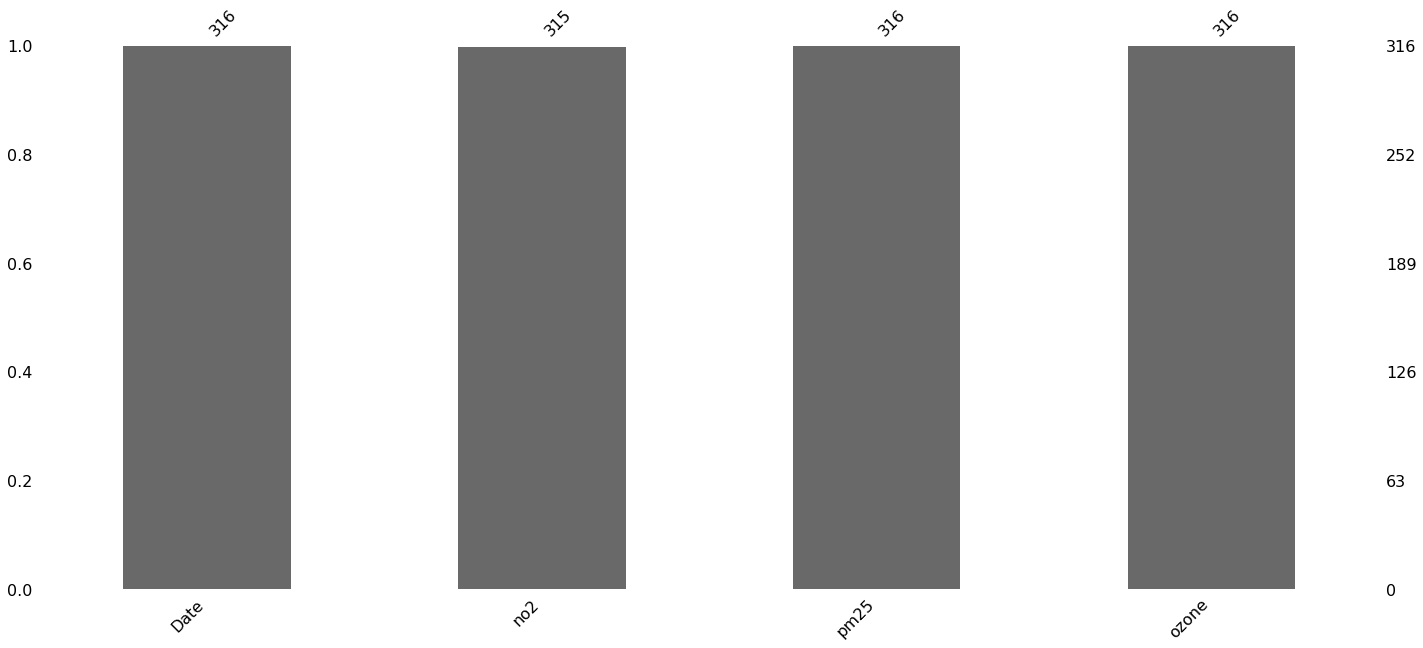

In [64]:
msno.bar(data_df)

In [65]:
# Interpolate missing data  
data_df = data_df.interpolate()
data_df

,Date,no2,pm25,ozone
0,2020-01-26,0.020,47.3,0.040
1,2020-01-27,0.042,24.6,0.041
2,2020-01-28,0.042,14.9,0.042
3,2020-01-29,0.031,11.0,0.042
4,2020-01-30,0.043,16.2,0.038
...,...,...,...,...
311,2020-12-02,0.053,29.7,0.033
312,2020-12-03,0.056,38.8,0.046
313,2020-12-04,0.052,23.6,0.036
314,2020-12-05,0.048,37.5,0.033


In [66]:
#https://raw.githubusercontent.com/datadesk/california-coronavirus-data/master/latimes-county-totals.csv
# target_df = pd.read_csv('/Users/kevinmarlis/Developer/Thesis/Covid/latimes-county-totals.csv')
target_df = pd.read_csv('https://raw.githubusercontent.com/datadesk/california-coronavirus-data/master/latimes-county-totals.csv')
target_df = target_df[target_df['county'] == 'Los Angeles']
target_df = target_df[['date', 'new_confirmed_cases', 'new_deaths']]
target_df = target_df.rename(columns={"date": "Date"})
target_df["Date"] = pd.to_datetime(target_df["Date"])
target_df = target_df.sort_values("Date", ignore_index=True)
target_df = target_df[(target_df['Date'] >= start_date) & (target_df['Date'] <= end_date)] 
target_df = target_df.interpolate(method ='linear', limit_direction ='backward', limit = 1)
target_df

,Date,new_confirmed_cases,new_deaths
0,2020-01-26,0.0,0.0
1,2020-01-27,0.0,0.0
2,2020-01-28,0.0,0.0
3,2020-01-29,0.0,0.0
4,2020-01-30,0.0,0.0
...,...,...,...
311,2020-12-02,5534.0,41.0
312,2020-12-03,7713.0,44.0
313,2020-12-04,8562.0,56.0
314,2020-12-05,9218.0,43.0


In [67]:
df = pd.merge(left=data_df, right=target_df)
df = df.set_index('Date', drop=True)
df

,no2,pm25,ozone,new_confirmed_cases,new_deaths
Date,,,,,
2020-01-26,0.020,47.3,0.040,0.0,0.0
2020-01-27,0.042,24.6,0.041,0.0,0.0
2020-01-28,0.042,14.9,0.042,0.0,0.0
2020-01-29,0.031,11.0,0.042,0.0,0.0
2020-01-30,0.043,16.2,0.038,0.0,0.0
...,...,...,...,...,...
2020-12-02,0.053,29.7,0.033,5534.0,41.0
2020-12-03,0.056,38.8,0.046,7713.0,44.0
2020-12-04,0.052,23.6,0.036,8562.0,56.0


In [68]:
df.to_csv('data.csv')

### Analysis

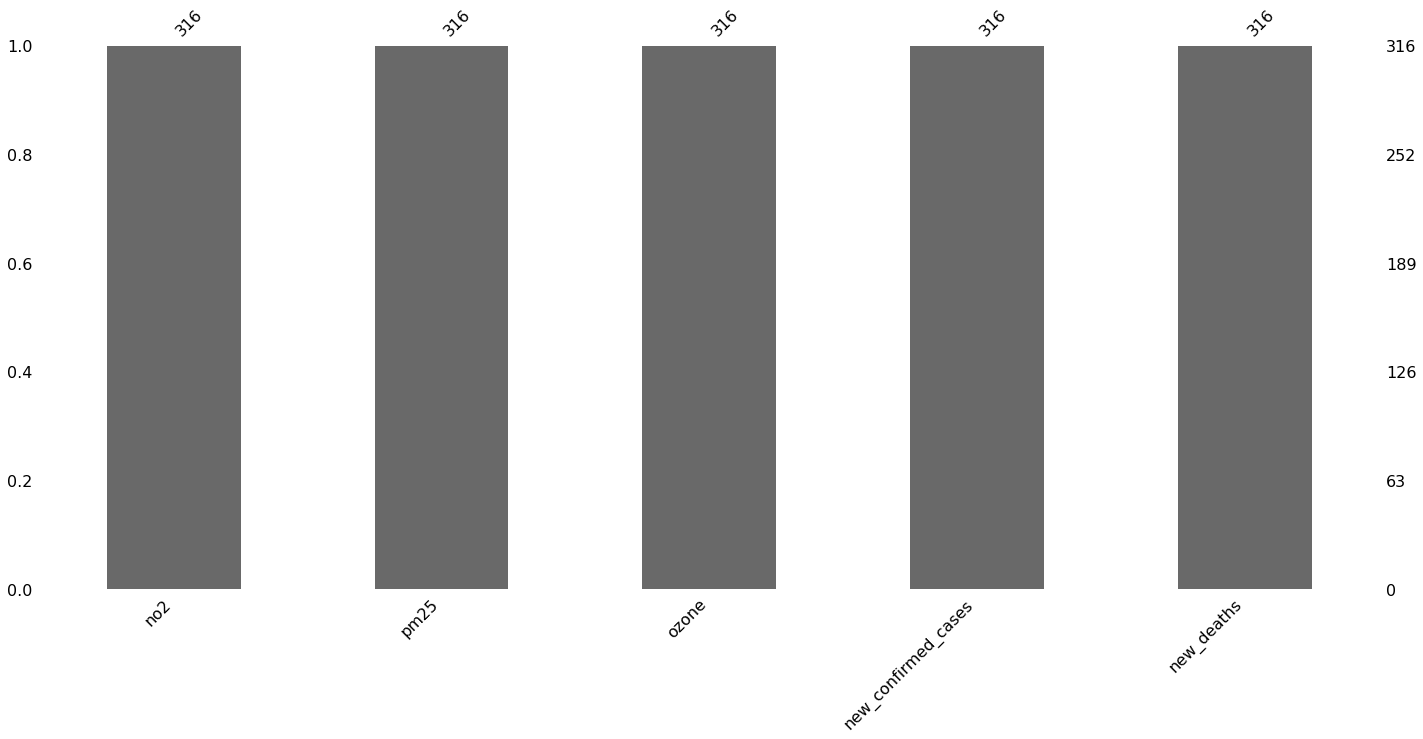

In [69]:
msno.bar(df)

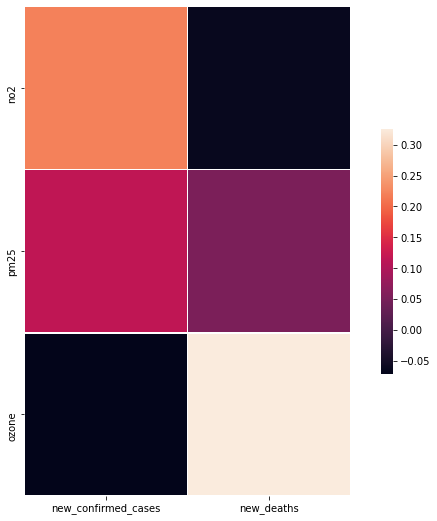

In [71]:
correlation = df.corr()
correlation = correlation.drop(correlation.index[[-2, -1]])
correlation = correlation.drop(correlation.columns[[0,1,2]], axis=1)
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(correlation,square=True, linewidths=.5, cbar_kws={"shrink": .5})

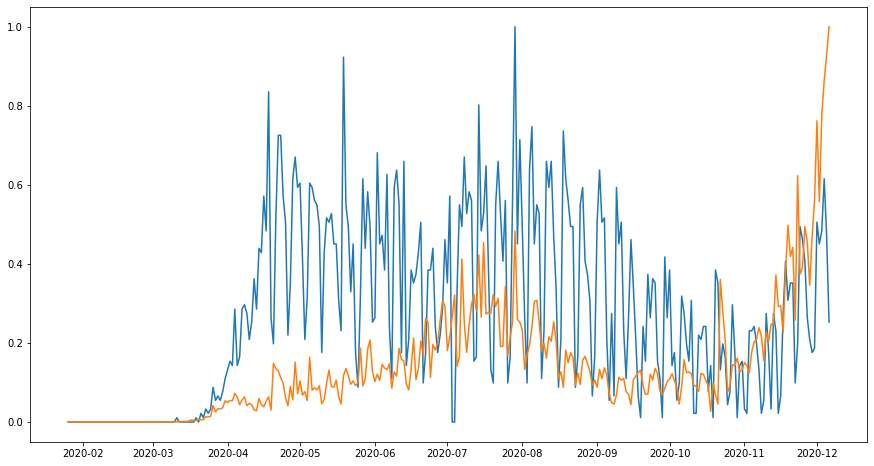

In [75]:
from sklearn import preprocessing

plt.figure(figsize=(15, 8))
plt.plot(df.index, preprocessing.minmax_scale(df['new_deaths'], feature_range=(0, 1), axis=0, copy=True))
plt.plot(df.index, preprocessing.minmax_scale(df['new_confirmed_cases'], feature_range=(0, 1), axis=0, copy=True))
plt.show()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f889ee226d0>,
      dtype=object)

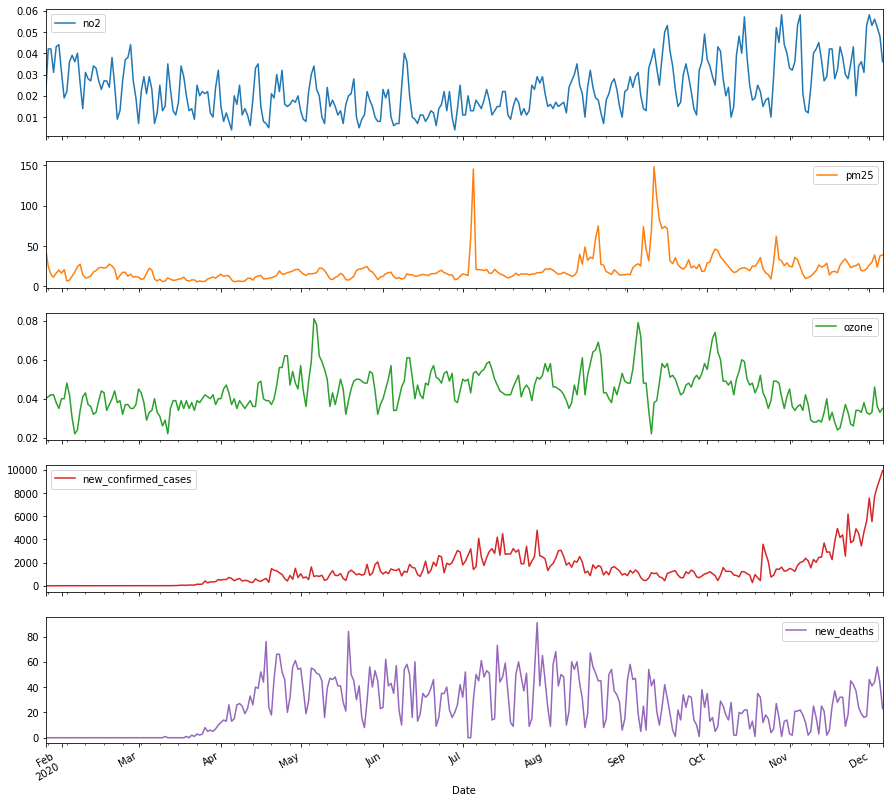

In [76]:
df.plot(subplots=True, figsize=(15, 15))